In [1]:
import torch
import torch.optim as optim
import torch.cuda as cuda
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from os.path import exists
from Dataset import Dataset, Dataset_warped
from convNet import convNet
from UNET import UNET
import cv2

In [2]:
BATCH = 2
EPOCHS = 20
LR = 0.000001
device = "cuda" if cuda.is_available() else "cpu"
dir_dataset = '../dataset2'
dataset = Dataset(dir = dir_dataset, transform=transforms.ToTensor())
model = convNet(6,3).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [3]:
if(exists("./weights.pth")):
  model.load_state_dict(torch.load('./weights.pth'))

In [4]:
length = dataset.__len__()
test = length//10
train = length - test
trainset, testset = random_split(dataset,[train,test])
trainset = DataLoader(trainset, batch_size=BATCH, shuffle=True, pin_memory=True,num_workers=2)
testset = DataLoader(testset, batch_size=1, shuffle=True)

In [5]:
lossFunction = torch.nn.SmoothL1Loss()
totalLoss = []
for epoch in range(EPOCHS):
    epochLoss = []
    for data in trainset:
        (F1,F2,F3) = data 
        #forward
        input = torch.cat([F1.to(device), F3.to(device)], dim=1)
        output = model(input)
        loss  = lossFunction(output , F2.to(device))
        epochLoss.append(loss.item())
        #backward
        loss.backward()
        optimizer. step()
        optimizer.zero_grad()
        del F1, F2, F3, loss, output, data
    print(sum(epochLoss)/len(epochLoss))
    totalLoss.append(sum(epochLoss)/len(epochLoss))

0.04589000022716331
0.03714617552314455
0.03606918419724759
0.035264202259953345
0.03503136195913703
0.034978861280057054
0.0346984501479523
0.0345296171186668
0.034287470267402906
0.03444268140197007
0.03391706836886406
0.0336940154014725
0.03375910535466146
0.03370537388540423
0.03379856046414556
0.03324169902653082
0.03315807078696696
0.03302695758478121
0.032697287163602914
0.032496437494481424


In [14]:
data = []
data = next(iter(testset))
(F1,F2,F3) = data
cuda.reset_peak_memory_stats(device="cuda")
with torch.no_grad():
    output = model(torch.cat([F1.to(device), F3.to(device)], dim=1))
img1 = F1.numpy()[0].transpose(1,2,0)
img2 = F2.cpu().numpy()[0].transpose(1,2,0)
img3 = F3.numpy()[0].transpose(1,2,0)
generated = output.cpu().detach().numpy()[0].transpose(1,2,0)
del output, data
cuda.reset_peak_memory_stats(device="cuda")

Text(0.5, 1.0, 'generated')

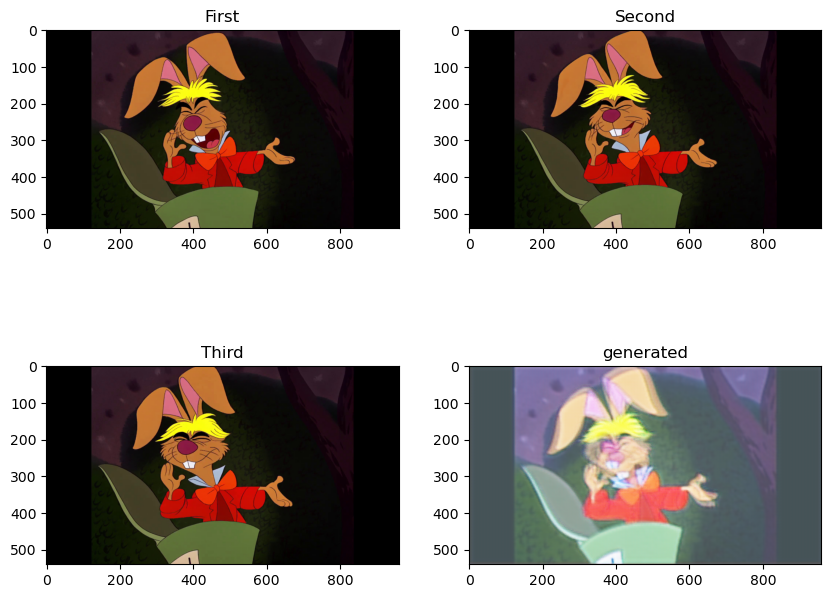

In [15]:
fNew = cv2.cvtColor(generated, cv2.COLOR_BGR2RGB)
f1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
f2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
f3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(10, 8))
fig.add_subplot(2, 2, 1) 
plt.imshow(f1)
plt.title("First")
fig.add_subplot(2, 2, 2)
plt.imshow(f2)
plt.title("Second")
fig.add_subplot(2, 2, 3)
plt.imshow(f3)
plt.title("Third")
fig.add_subplot(2, 2, 4)
plt.imshow(fNew)
plt.title("generated")

In [10]:
torch.save(model.state_dict(), "weights-conv.pth")